In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as fp:
        return pickle.load(fp)
    
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [3]:
from keras import backend as K
from keras.preprocessing import image
import skimage
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras import optimizers

from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50 as resnet
from keras.applications.resnet50 import preprocess_input as resnet_pp

from keras.optimizers import Adam

def normalize(a):
    return (a - np.min(a))/np.ptp(a)

Using TensorFlow backend.


In [10]:
main_path = os.path.abspath("./POETdataset/PascalImages/")
class_names = ['dog', 'aeroplane', 'boat', 'bicycle', 'cat', 'cow', 'diningtable', 'horse', 'motorbike','sofa']
IMG_SIZE = 60*4*2
PATCH_WIDTH = 60*2
SMALLER_IMG_SIZE = 150
T = int(IMG_SIZE/PATCH_WIDTH)**2
new_dir = 'soft_attention_features2'
new_dir_img = 'soft_attention_images'
name_to_class_dict = {class_name: i for i, class_name in enumerate(class_names)}
train_ids, test_ids = load_object('train_ids.pkl'), load_object('test_ids.pkl')

# files_list = [glob.glob(os.path.join(main_path, '%s*' %class_)) for class_ in class_names]

# ids_ = []
# final_files_list = []
# labels = []
# for label, files in enumerate(files_list):
#     one_list = []
#     for file in files:
#         id_ = ''.join(file.split('/')[-1].split('.')[0].split('_')[1:])
#         if id_ not in ids_:
#             one_list.append(file)
#             ids_.append(id_)
#             labels.append(label)
#     final_files_list.append(one_list)
    

# files_dict = {class_name.replace('*', ''): class_files for class_name, class_files in zip(class_names, final_files_list)}

In [5]:
import gc

# Build a model by adding preprocessing before the pretrained CNN
def get_feature_extraction_model(img_size):
    cnn_object, pp_function = _get_pretrained_model()
    model = keras.models.Sequential()
    cnn_model = cnn_object(weights='imagenet', include_top=False, pooling='max')
    model.add(keras.layers.Lambda(pp_function, name='preprocessing', input_shape=(img_size, img_size, 3)))
    model.add(cnn_model)
    return model

# Unpacking information from the models dictionary
def _get_pretrained_model():
    cnn_object = resnet
    pp_function = resnet_pp
    return cnn_object, pp_function

def _get_patches(x, patch_width):
    patches = np.squeeze(np.asarray(skimage.util.view_as_windows(x, window_shape=(1,patch_width,patch_width,3), 
                                                                 step=(1,patch_width,patch_width,3)), dtype=np.int))
    len_ = x.shape[0]
    del x
    gc.collect()
    print(patches.shape)
    patches = patches.reshape(len_, int(IMG_SIZE/patch_width)**2, patch_width, patch_width, 3)
    return patches

def _load_images(files, img_size=IMG_SIZE):
    return np.asarray([image.img_to_array(image.load_img(file, target_size=(img_size, img_size))) for file in files], dtype=np.int)

def get_features(files, model, patch_width):
    # Load images based on the size of the Lambda layer 
    # provided as the first layer before the pretrained CNN
    x = _load_images(files)
    patches = _get_patches(x, patch_width = patch_width)
    patches_shape = patches.shape
    features = model.predict(patches.reshape(-1, patch_width, patch_width, 3), verbose=1)
    print(features.shape)
    del x
    del patches
    gc.collect()
    return features.reshape(patches_shape[0], patches_shape[1], 2048)

Patch feature extraction

In [6]:
model = get_feature_extraction_model(img_size = PATCH_WIDTH)

In [7]:
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
def extract_features(ids, name_to_class_dict, new_dir, mode):
    print("Extracting features in mode", mode)
    for class_name, class_number in name_to_class_dict.items():
        files = []
        print(class_name)
        for i, file_name in enumerate(ids):
            if class_name in file_name:
                files.append(main_path + os.path.sep + file_name)
        features = get_features(files, model, PATCH_WIDTH)

        print(features.shape)
        save_object(features, new_dir + os.path.sep + class_name + '_'+mode+'_features.pkl')
    
extract_features(train_ids, name_to_class_dict, new_dir, mode='train')
extract_features(test_ids, name_to_class_dict, new_dir, mode='test')
    
# for class_number, (class_name, files) in enumerate(files_dict.items()):
#     print(class_name)
#     features = get_features(files, model, PATCH_WIDTH)
#     print(features.shape)
#     save_object(features, new_dir + os.path.sep + class_name + '_features.pkl')

Extracting features in mode train
dog
(1128, 4, 4, 120, 120, 3)
18048/18048 [==============================] - 25s 1ms/step
(18048, 2048)
(1128, 16, 2048)
aeroplane
(599, 4, 4, 120, 120, 3)
9584/9584 [==============================] - 13s 1ms/step
(9584, 2048)
(599, 16, 2048)
boat
(454, 4, 4, 120, 120, 3)
7264/7264 [==============================] - 10s 1ms/step
(7264, 2048)
(454, 16, 2048)
bicycle
(480, 4, 4, 120, 120, 3)
7680/7680 [==============================] - 10s 1ms/step
(7680, 2048)
(480, 16, 2048)
cat
(943, 4, 4, 120, 120, 3)
15088/15088 [==============================] - 20s 1ms/step
(15088, 2048)
(943, 16, 2048)
cow
(265, 4, 4, 120, 120, 3)
4240/4240 [==============================] - 6s 1ms/step
(4240, 2048)
(265, 16, 2048)
diningtable
(427, 4, 4, 120, 120, 3)
6832/6832 [==============================] - 9s 1ms/step
(6832, 2048)
(427, 16, 2048)
horse
(428, 4, 4, 120, 120, 3)
6848/6848 [==============================] - 9s 1ms/step
(6848, 2048)
(428, 16, 2048)
motorbike
(4

In [8]:
if not os.path.exists(new_dir_img):
    os.makedirs(new_dir_img)
    
def save_images(ids, name_to_class_dict, new_dir, mode):
    print("Saving images in mode", mode)
    for class_name, class_number in name_to_class_dict.items():
        files = []
        print(class_name)
        for i, file_name in enumerate(ids):
            if class_name in file_name:
                files.append(main_path + os.path.sep + file_name)
#         features = get_features(files, model, PATCH_WIDTH)
        images = _load_images(files, img_size=SMALLER_IMG_SIZE)
        print(images.shape)
        save_path =  new_dir + os.path.sep + class_name + '_'+mode+'.pkl'
        print("Saving...", save_path)
        save_object(images, save_path)
    
save_images(train_ids, name_to_class_dict, new_dir_img, mode='train')
save_images(test_ids, name_to_class_dict, new_dir_img, mode='test')
    
# for class_number, (class_name, files) in enumerate(files_dict.items()):
#     print(class_name)
# #     features = get_features(files, model, PATCH_WIDTH)
# #     print(features.shape)
#     images = _load_images(files, img_size=smaller_size)
#     print(images.shape)
#     save_object(images, new_dir_img + os.path.sep + class_name + '.pkl')

Saving images in mode train
dog


KeyboardInterrupt: 

In [11]:
def load_X_y_images(mode):
    X = []
    y = []
    org_images = []
    for class_name, class_number in name_to_class_dict.items():
        classfeatures_path = os.path.abspath(os.path.join('.', new_dir, class_name + '_'+mode+'_features.pkl'))
        classimages_path = os.path.abspath(os.path.join('.', new_dir_img, class_name + '_' + mode +'.pkl'))
        print(classfeatures_path)

        features = load_object(classfeatures_path).reshape(-1,T,2048)
        images = load_object(classimages_path)
        org_images.append(images)

        print(features.shape)
        X.append(features)
        y.append([class_number] * features.shape[0])

    X = np.concatenate(X)
    y = np.concatenate(y)
    y = keras.utils.to_categorical(y)
    org_images = np.concatenate(org_images)
    return X, y, org_images
    
X_train, y_train, images_train = load_X_y_images(mode='train')
X_train, y_train, images_train = unison_shuffled_copies(X_train, y_train, images_train)
X_test, y_test, images_test = load_X_y_images(mode='test')

X_train.shape, y_train.shape, images_train.shape, X_test.shape, y_test.shape, images_test.shape

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/dog_train_features.pkl
(1128, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/aeroplane_train_features.pkl
(599, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/boat_train_features.pkl
(454, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/bicycle_train_features.pkl
(480, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/cat_train_features.pkl
(943, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/cow_train_features.pkl
(265, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/diningtable_train_features.pkl
(427, 16, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_features2/horse_train_features.pkl
(428, 16, 2048)
/home/mikey/Repos/

((5517, 16, 2048),
 (5517, 10),
 (5517, 150, 150, 3),
 (614, 16, 2048),
 (614, 10),
 (614, 150, 150, 3))

In [12]:
# adjust back to original size
# org_images = np.array([skimage.transform.rescale(image, 4) for image in org_images])

In [13]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
# sss.get_n_splits(X, y)

# train_index, test_index = next(sss.split(X, y))
# X_train, X_test = X[train_index], X[test_index]
# y_train, y_test = y[train_index], y[test_index]

# X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(train_index), len(test_index)

In [14]:
np.max(X_train[0]), np.min(X_train[0])

(60.25065, -4.371021)

In [73]:
n_epochs = 100
batch_size = 32
T = X_train.shape[1]
lstm_time = 10 #analogous to fixations ?

def _get_initial_lstm(features, H, D=2048):
    with tf.variable_scope('initial_lstm'):
        features_mean = tf.reduce_mean(features, 1)

        w_h = tf.get_variable('w_h', [D, H])
        b_h = tf.get_variable('b_h', [H])
        h = tf.nn.tanh(tf.matmul(tf.ones_like(features_mean), w_h) + b_h)

        w_c = tf.get_variable('w_c', [D, H])
        b_c = tf.get_variable('b_c', [H])
        c = tf.nn.tanh(tf.matmul(tf.ones_like(features_mean), w_c) + b_c)
        return [c, h]
               
tf.reset_default_graph()

X_input = tf.placeholder(tf.float32, [None, T, 2048], name='X')
labels = tf.placeholder(tf.int32, [None, y_train.shape[1]], name='labels')

rnn_units = 32

c,h = _get_initial_lstm(X_input[:,:,:], H=rnn_units)

context = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
# context = tf.layers.dropout(context, rate=0.25)

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_units)

c_s = []
h_s = []
contexts = []
attentions = []
# contexts.append(context)
att_input = tf.nn.tanh(X_input)
ContextDense = tf.layers.Dense(2048, activation='tanh', 
                          kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=.001),
                          activity_regularizer=tf.contrib.layers.l2_regularizer(scale=.001))
for t in range(lstm_time):
    # encoded lstm context to a specific size 
    context = ContextDense(context)
#     context = tf.layers.dropout(context, rate=0.1)
    # squeeze the features sfrom Resnet
    
    # how lstm context and patch info relate
    att = tf.einsum('bi,bti->bt', context, att_input)
    att = tf.nn.softmax(att)
#     attention_loss = 
    
    lstm_input = tf.einsum('bt,bti->bi', att, X_input)
    
    context, (c, h) = lstm_cell(inputs=lstm_input, state=[c, h])
    context = tf.layers.dropout(context, rate=0.2)
    c_s.append(c)
    h_s.append(h)
    contexts.append(context)
    attentions.append(att)

Dense = tf.layers.Dense(units=32, activation=tf.nn.relu)
Logits = tf.layers.Dense(units=y_train.shape[1])
probabilities_list = []
for context in contexts:
    dense = Dense(context)
    dense = tf.layers.dropout(dense, rate=0.2)

    # Logits Layer
    logits = Logits(dense)
    logits = tf.layers.dropout(logits, rate=0.2)

    classes = tf.argmax(logits, axis=1)
    probabilites = tf.nn.softmax(logits)
    probabilities_list.append(probabilites)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
l2_loss = tf.losses.get_regularization_loss()
loss += l2_loss

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step()
)

accuracy = tf.reduce_mean(tf.cast(tf.equal(classes, tf.argmax(labels, 1)), tf.float32))

init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init_g)
    sess.run(init_l)
    learning_rate_ = 0.0001
    changed_learning_rate = False
    
        # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        train_acc = []
        for b in range(0, X_train.shape[0], batch_size):
            _, acc = sess.run([train_op, accuracy], feed_dict={
                                                            X_input: X_train[b:b+batch_size],
                                                            labels: y_train[b:b+batch_size],
                                                            learning_rate: learning_rate_
                                                        })
            train_acc.append(acc)
#             print(acc)
        
        acc, c_s_, h_s_, context_, atts_, test_proba_, probabilities_list_ = sess.run([accuracy, c_s, h_s, 
                                                                  context, attentions, probabilites,
                                                                 probabilities_list], feed_dict={
                                                X_input: X_test,
                                                labels: y_test
                                            })
        if acc > 0.8 and not changed_learning_rate:
            learning_rate_ = learning_rate_ / 10.
            changed_learning_rate = True
            print("Adjusted learning rate to", learning_rate_)
        
        if acc > 0.97:
            break
            
        print("Train:", np.mean(train_acc))
        print("Test:", acc)
        train_acc = []
#         print(atts_[0])

Epoch: 0
Train: 0.13294798
Test: 0.19543974
Epoch: 1
Train: 0.22894898
Test: 0.23615634
Epoch: 2
Train: 0.2562111
Test: 0.262215
Epoch: 3
Train: 0.2713845
Test: 0.27687296
Epoch: 4
Train: 0.28023568
Test: 0.27850163
Epoch: 5
Train: 0.28420967
Test: 0.2801303
Epoch: 6
Train: 0.2930608
Test: 0.31433225
Epoch: 7
Train: 0.35176745
Test: 0.38762215
Epoch: 8
Train: 0.40794522
Test: 0.4267101
Epoch: 9
Train: 0.4354852
Test: 0.43485343
Epoch: 10
Train: 0.450478
Test: 0.4397394
Epoch: 11
Train: 0.452201
Test: 0.4397394
Epoch: 12
Train: 0.48242277
Test: 0.47394136
Epoch: 13
Train: 0.55043906
Test: 0.51954395
Epoch: 14
Train: 0.60417134
Test: 0.5879479
Epoch: 15
Train: 0.6551801
Test: 0.64006513
Epoch: 16
Train: 0.7005197
Test: 0.67752445
Epoch: 17
Train: 0.74766564
Test: 0.7394137
Epoch: 18
Train: 0.7816252
Test: 0.7654723
Epoch: 19
Adjusted learning rate to 1e-05
Train: 0.8381642
Test: 0.8029316
Epoch: 20
Train: 0.8587567
Test: 0.8013029
Epoch: 21
Train: 0.86399513
Test: 0.8110749
Epoch: 22
Tra

In [52]:
np.array(c_s_).shape, np.array(h_s_).shape, np.array(context_).shape, np.array(atts_).shape

((3, 614, 32), (3, 614, 32), (614, 32), (3, 614, 16))

In [53]:
atts_ = np.array(atts_)
images_test = np.array(images_test)
probabilities_list_ = np.array(probabilities_list_)

In [54]:
unique, counts = np.unique(np.argmax(y_test, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '126'],
       ['aeroplane', '67'],
       ['boat', '50'],
       ['bicycle', '53'],
       ['cat', '105'],
       ['cow', '30'],
       ['diningtable', '47'],
       ['horse', '48'],
       ['motorbike', '50'],
       ['sofa', '38']], dtype='<U21')

In [55]:
unique, counts = np.unique(np.argmax(test_proba_, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '126'],
       ['aeroplane', '69'],
       ['boat', '45'],
       ['bicycle', '50'],
       ['cat', '107'],
       ['cow', '20'],
       ['diningtable', '45'],
       ['horse', '54'],
       ['motorbike', '55'],
       ['sofa', '43']], dtype='<U21')

In [56]:
np.array(probabilities_list_).shape

(3, 614, 10)

motorbike 0.12689877
dog 0.108036235
cat 0.10789529
horse 0.10189427
diningtable 0.10074555
bicycle 0.09853301
cow 0.09685249
sofa 0.094114624
boat 0.08652331
aeroplane 0.07850645
(480, 480, 3)


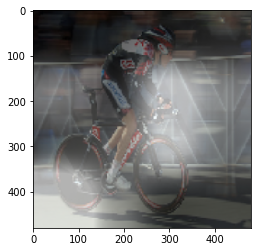

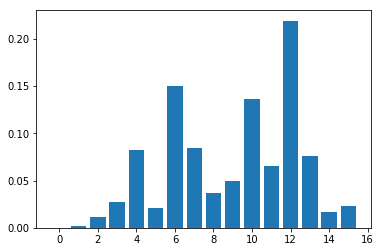

motorbike 0.74283326
bicycle 0.14793205
sofa 0.021481043
aeroplane 0.019497946
cow 0.019403066
cat 0.016844783
horse 0.011588221
diningtable 0.008140896
dog 0.00746303
boat 0.004815722
(480, 480, 3)


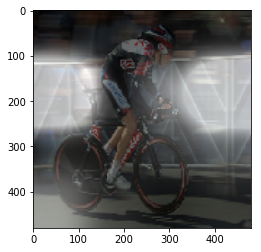

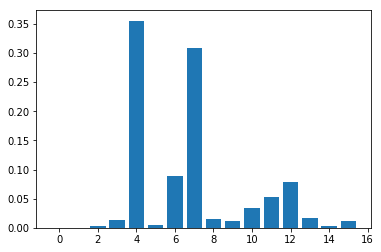

motorbike 0.55740666
bicycle 0.3941433
aeroplane 0.016731873
cat 0.008641367
sofa 0.0068874233
cow 0.005456083
horse 0.003975624
boat 0.003940136
diningtable 0.0015077295
dog 0.0013098157
(480, 480, 3)


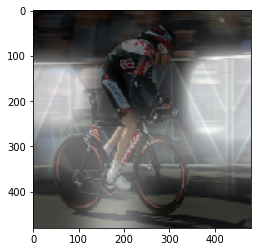

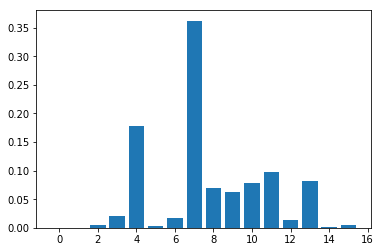

In [72]:
from scipy import signal
from scipy import ndimage

def get_att(t, n):
    return atts_[t, n, :]

class_name = 'bicycle'
class_id = name_to_class_dict[class_name]
class_mask = np.argmax(y_test, axis=1) == class_id
class_images = images_test[class_mask]
class_test_proba = test_proba_[class_mask]
class_proba_list = probabilities_list_[:,class_mask,:]
image_n = 16
rescale = IMG_SIZE / SMALLER_IMG_SIZE

for t in range(atts_.shape[0]):
    image = class_images[image_n]
    proba_res = class_proba_list[t,image_n,:]
#     print(proba_res)
#     print(class_to_name_dict[np.argmax(proba_res)])
    proba_res = [(i, proba) for i, proba in enumerate(proba_res)]
    proba_res.sort(key= lambda pair: pair[1], reverse=True)
#     print(proba_res)
    for i, proba in enumerate(proba_res):
        print(class_to_name_dict[proba[0]], proba[1])
    
    
    if rescale != 1:
        chosen_img = np.array(normalize(skimage.transform.rescale(image.copy(), rescale))) * 500
    else:
        chosen_img = image.copy()
    print(chosen_img.shape)
        
    chosen_attention = get_att(t,image_n)
#     attended_patch = np.argmax(chosen_attention)
    
#     plt.imshow(chosen_img)
#     plt.show()
    
    result = np.zeros_like(chosen_img)
    for attended_patch_n in range(T):
        att_prob = chosen_attention[attended_patch_n]
#         print(att_prob)
#         print(attended_patch)
#         print(attended_patch_n/(IMG_SIZE/PATCH_WIDTH))
#         print(int(attended_patch%(IMG_SIZE/PATCH_WIDTH)))
        row = int(attended_patch_n/(IMG_SIZE/PATCH_WIDTH))
        col = int(attended_patch_n%(IMG_SIZE/PATCH_WIDTH))
#         print(row, col)
        from_y = row*PATCH_WIDTH
        to_y = from_y+PATCH_WIDTH

        from_x = col*PATCH_WIDTH
        to_x = from_x+PATCH_WIDTH
#         print(from_x, from_y)
        result[from_y:to_y, from_x:to_x, :] = np.ones_like(result[from_x:to_x,from_y:to_y,:]) * 255 * att_prob
    
#         cropped_img = chosen_img[from_x:to_x,
#                     from_y:to_y,:]
#         chosen_img[from_x:to_x,
#                     from_y:to_y,:] = cropped_img * att_prob + 100
#         print(adjusted_img.shape)

    
#     scharr = np.array([[ 0, 0,  0],
#                        [0, 1, 0],
#                        [ 0, 0,  0]]) # Gx + j*Gy
#     adjusted_img = signal.convolve2d(adjusted_img[:,:,0], scharr, boundary='symm', mode='same')
#     print(adjusted_img.max())
#     plt.imshow(chosen_img)
#     plt.show()
    
    result = result / 255.
    chosen_img = chosen_img / 255.
    result = ndimage.gaussian_filter(result, sigma=32) * 8
    result[result > 1] = 1
    res = normalize(0.3 * chosen_img + result)
    plt.imshow(res)
    plt.show()
    
    plt.bar(range(atts_.shape[2]), chosen_attention)
    plt.show()

In [42]:
np.max(result)

1.0

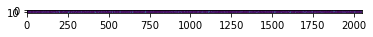

In [43]:
plt.imshow(X_test[image_n])

Normalized confusion matrix


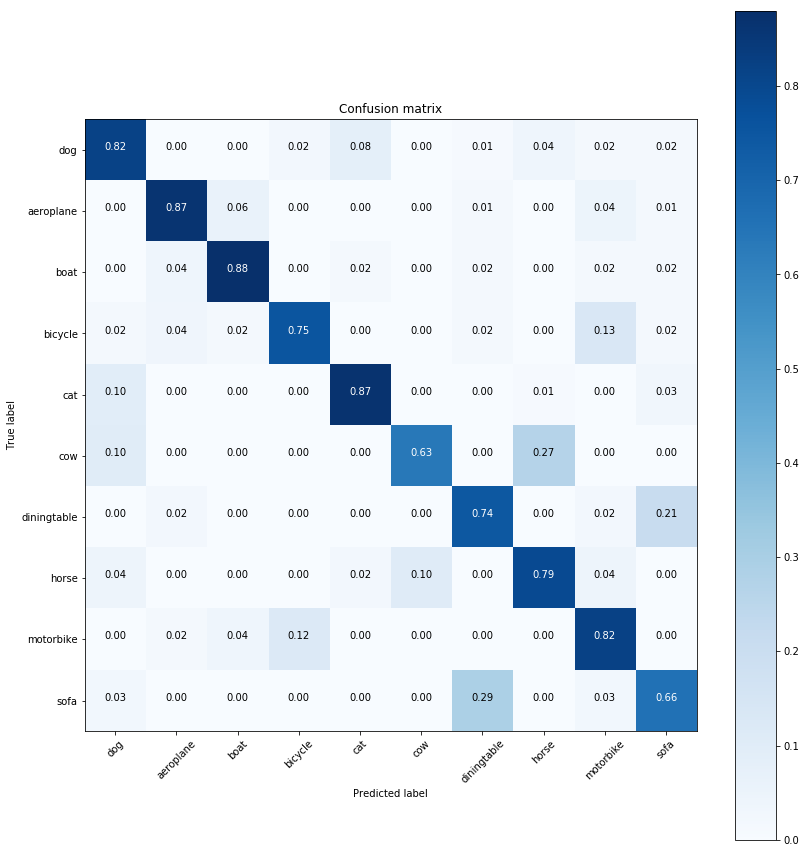

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt.gcf()

from sklearn.metrics import confusion_matrix

y_pred_proba = test_proba_

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape

cnf_matrix = confusion_matrix(y_test_argmax, y_pred)

import itertools

plt.figure(figsize=(12,12))
fig = plot_confusion_matrix(cnf_matrix, class_names, normalize=True)